<a href="https://colab.research.google.com/github/durml91/Public-share/blob/main/Copy_of_Basic_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

### Imports

In [ ]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as  jr
from functools import partial
rng = jr.PRNGKey(2023)

import scipy

import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


### Data loading

#### Circle

In [ ]:
def sample_circle(J):
    
    alphas = jnp.linspace(0, 2*jnp.pi*(1-1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs,ys], axis=1) #.stack is the least "intrusive of the concatenation type functions - just puts the two into a list
    
    return mf

In [ ]:
J=14
mf = sample_circle(J)
plt.scatter(mf[:,0], mf[:,1])

NameError: ignored

#### Spiral

In [ ]:
J1=10

a = 1
b = 0.1
thetas = jnp.linspace(0, 2*jnp.pi,J1) #generates array of number from 0 to 2pi
xs = a*jnp.cos(thetas)*jnp.exp(b*thetas)
ys = a*jnp.sin(thetas)*jnp.exp(b*thetas)

mf = jnp.stack([xs,ys],axis=1)
###########################################
J2=20
thetas2 = jnp.linspace(2*jnp.pi, 4*jnp.pi,J2) #generates array of number from 0 to 2pi
xs2 = a*jnp.cos(thetas2)*jnp.exp(b*thetas2)
ys2 = a*jnp.sin(thetas2)*jnp.exp(b*thetas2)

mf2 = jnp.stack([xs2,ys2],axis=1)
###########################################
J3=30
thetas3 = jnp.linspace(4*jnp.pi, 6*jnp.pi,J3) #generates array of number from 0 to 2pi
xs3 = a*jnp.cos(thetas3)*jnp.exp(b*thetas3)
ys3 = a*jnp.sin(thetas3)*jnp.exp(b*thetas3)

mf3 = jnp.stack([xs3,ys3] ,axis=1)
##########################################
mf = jnp.concatenate([mf,mf2, mf3], axis=0)

In [ ]:
plt.scatter(mf[:,0], mf[:,1])

### Forward DE

In [ ]:
beta_max=3
beta_min=0.001


def beta_t(t):
    return beta_min + t*(beta_max - beta_min)
def alpha_t(t):
    return t*beta_min + 0.5*(t**2)*(beta_max - beta_min)
def drift(x,t):
    return -0.5*beta_t(t)*x
def dispersion(t):
    return jnp.sqrt(beta_t(t))
def mean_factor(t):
    return jnp.exp(-0.5*alpha_t(t))
def var(t):
    return 1- jnp.exp(-alpha_t(t))

Monte carlo stuff with the marginals of the distribution

### Stein score function

Important thing to note here is the transition kernel of the OH process, namely: $p_{t|0}(x_{t}|x_{0}) = \mathcal{N}(\exp(-\frac{1}{2}t)\boldsymbol{x}_{0}, (1-\exp(-t))\boldsymbol{I})$  - so we are just group mf together but think of the vector as in $\mathbb{R}^2$. Here this is basically some weird sample marginalisation.

In [ ]:
from jax.scipy.special import logsumexp

def log_hat_pt(x,t):
    N = mf.shape[0] #get number of observations
    """calculate transition kernel"""
    means = mf * mean_factor(t)
    v = var(t)
    #next bit comes from the inside of the normal distribution
    exponent = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    return logsumexp(exponent, axis =0, b=1/N) # b is the scaling factor for the exponential term

In [ ]:
"""Get Stein score"""
nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))

#### Plot vector field

In [ ]:
"""helper function"""

def plot_score(score, t, area_min=-1, area_max=1):
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

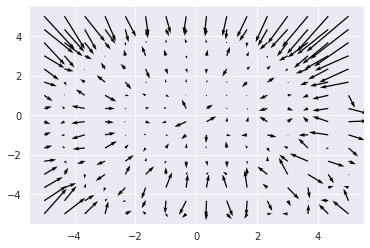

In [ ]:
plot_score(nabla_log_hat_pt, 0.25, -5, 5)

### Reverse DE

Time-steps

In [ ]:
R=1000
train_ts = jnp.arange(1, R)/(R-1)

Reverse SDE

In [ ]:
@partial(jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):
    """
    rng: random number generator (JAX rng)
    N: dimension in which the reverse SDE runs
    N_initial: How many samples from the initial distribution N(0, I), number
    forward_drift: drift function of the forward SDE (we implemented it above)
    disperion: dispersion function of the forward SDE (we implemented it above)
    score: The score function to use as additional drift in the reverse SDE
    ts: a discretization {t_i} of [0, T], shape 1d-array
    """
    def f(carry, params): #this function computes the next random variable along the reverse SDE trajectory
        t, dt = params
        x, rng = carry
        rng, step_rng = jr.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = jr.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise #EM scheme
        return (x, rng), ()
    
    rng, step_rng = jr.split(rng)
    initial = jr.normal(step_rng, (n_samples, N)) #this generates the standard Gaussian that we sample from in order to start the reverse process
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, rng), params) #scan just iterates over a particular value whilst fixing a state - so here we fix (initial, rng) and apply function f on each element of params
    #why do we have the weird x thing - I think it is because scan outputs the fixed state/carry so to be able to extract x we need to output scan like this
    #(x, _), _ 
    return x

#params are just a stack (side by side) of the first column being the times and

Reverse ODE

In [ ]:

def reverse_ode(rng, N, n_samples, beta_t, score, ts=train_ts):
    def f(carry, params): #this function computes the next random variable along the reverse SDE trajectory
        t, dt = params
        x = carry
        t = jnp.ones((x.shape[0], 1)) * t
        x = x + dt*(-0.5*beta_t(1-t)*x + score(x,1-t))
        return (x), ()
    
    initial = jr.normal(rng, (n_samples, N)) #this generates the standard Gaussian that we sample from in order to start the reverse process
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x), _ = scan(f, initial, params) #scan just iterates over a particular value whilst fixing a state - so here we fix (initial, rng) and apply function f on each element of params
    #why do we have the weird x thing - I think it is because scan outputs the fixed state/carry so to be able to extract x we need to output scan like this
    #(x, _), _ 
    return x

#params are just a stack (side by side) of the first column being the times and

In [ ]:
# samples = reverse_ode(rng, 2, 5000, beta_t, nabla_log_hat_pt, train_ts)

In [ ]:
!pip install diffrax
import diffrax as dfx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 12.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [ ]:
def reverse_ODE(score, int_beta=alpha_t, data_shape=2, dt0=0.1, t1=R, key=rng):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + score(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [ ]:
import functools as ft

In [ ]:
sample_key = jr.split(sample_key, sample_size**2)

#### Plot reverse trajectory

In [ ]:
#helper function

def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

In [ ]:
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, nabla_log_hat_pt)
plot_heatmap(samples[:, [0,1]], -5, 5)

Bounded perturbation - basically add 1 to the score

In [ ]:
perturbed_score = lambda x, t: nabla_log_hat_pt(x, t) + 1
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, perturbed_score)
plot_heatmap(samples[:, [0,1]], -5, 5)

### Training

#### Equinox attempt

In [ ]:
!pip install equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 6.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [ ]:
import equinox as eqx

In [ ]:
class ApproximateScore(eqx.Module):
  layers: list


  def __init__(self, in_size, out_size, key):
    key1, key2, key3, key4, key5 = jr.split(key, 5)
    self.layers = [eqx.nn.Linear(in_size, 256, key=key1),
                   eqx.nn.Linear(256, 512, key=key2),
                   eqx.nn.Linear(512,512, key=key3),
                   eqx.nn.Linear(512,256, key=key4),
                   eqx.nn.Linear(256, out_size, key=key5)]

  def __call__(self, x, t):
    t = jnp.concatenate([t-0.5, jnp.cos(2*jnp.pi*t)],axis=1)
    x=jnp.concatenate([x,t], axis=1)
    for layer in self.layers[:-1]:
      x = jax.nn.gelu(layer(x))

    return self.layers[-1](x)

In [ ]:
import optax

batch_size = 200

x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))
shap = x.shape[1]
score_model = ApproximateScore(in_size = shap, out_size = shap, key=rng)


lr = (1e-3)

optimiser = optax.adabelief(lr)
opt_state = optimiser.init(eqx.filter(score_model, eqx.is_inexact_array))

TypeError: ignored

In [ ]:
def loss_fn(model, rng, batch):
  rng, step_rng = jr.split(rng)
  N_batch = batch.shape[0]
  t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1) #random uniform values
  mean_coeff = mean_factor(t)
  vs = var(t)
  stds = jnp.sqrt(vs)
  rng, step_rng = jr.split(rng)
  noise = jr.normal(step_rng, batch.shape)
  xt = batch * mean_coeff + noise *stds # here we only need the forward process so we calculate value
  output = score_model.apply(params, xt,t)
  loss = jnp.mean((noise + output*vs)**2) #weird noise loss from DDPMs
  return loss


In [ ]:
@partial(jit, static_argnums=[4])
def update_step(rng, batch, opt_state, model):
    loss_fn_new = eqx.filter_value_and_grad(loss_fn)
    val, grads = loss_fn_new(model, rng, batch) #backprop step
    updates, opt_state = optimiser.update(grads, opt_state)# equivalent to SGD step
    score_model = eqx.apply_updates(score_model, updates) #update network's parameters
    return score_model, opt_state

#### Flax NN

In [ ]:
import flax.linen as nn

class ApproximateScore(nn.Module):
    
    @nn.compact
    def __call__(self,x,t):
        in_size = x.shape[1]
        #n_hidden = 256
        act = nn.gelu
        t = jnp.concatenate([t-0.5, jnp.cos(2*jnp.pi*t)],axis=1)
        x=jnp.concatenate([x,t], axis=1)
        x = nn.Dense(512)(x)
        x = nn.gelu(x)
        x = nn.Dense(512)(x)
        x = nn.gelu(x)
        x = nn.Dense(512)(x)
        x = nn.gelu(x)
        x = nn.Dense(512)(x)
        x = nn.gelu(x)
        x = nn.Dense(in_size)(x)

        return x
        

Initialise

In [ ]:
import optax

batch_size = 60

x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))

score_model = ApproximateScore()
params = score_model.init(rng, x, time)

optimiser = optax.adam(1e-3)
opt_state = optimiser.init(params)

Loss

In [ ]:
def loss_fn(params, model, rng, batch):
  rng, step_rng = jr.split(rng)
  N_batch = batch.shape[0]
  t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1) #random uniform values
  mean_coeff = mean_factor(t)
  vs = var(t)
  stds = jnp.sqrt(vs)
  rng, step_rng = jr.split(rng)
  noise = jr.normal(step_rng, batch.shape)
  xt = batch * mean_coeff + noise *stds # here we only need the forward process so we calculate value
  output = score_model.apply(params, xt,t)
  loss = jnp.mean((noise + output*vs)**2) #weird noise loss from DDPMs
  return loss


Update_step

In [ ]:
@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch) #backprop step
    updates, opt_state = optimiser.update(grads, opt_state)# equivalent to SGD step
    params = optax.apply_updates(params, updates) #update network's parameters
    return val, params, opt_state

### Main() run

In [ ]:
N_epochs = 10_001
train_size = mf.shape[0]
batch_size = 5
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = jr.split(rng)
    perms = jr.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = jr.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 1000 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))

Epoch 0 	, Loss 0.990963 
Epoch 1000 	, Loss 0.744009 
Epoch 2000 	, Loss 0.825536 
Epoch 3000 	, Loss 0.715611 
Epoch 4000 	, Loss 0.803103 
Epoch 5000 	, Loss 0.921236 
Epoch 6000 	, Loss 0.818004 
Epoch 7000 	, Loss 0.616316 
Epoch 8000 	, Loss 0.831544 
Epoch 9000 	, Loss 0.798411 
Epoch 10000 	, Loss 0.607404 


### Plot results

In [ ]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, trained_score)
plot_heatmap(samples)

In [ ]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 10000, drift, dispersion, trained_score)
plot_heatmap(samples,-5, 5)
#plot.scatter(samples[:,0], samples[:,1])

## MNIST attempt


In [ ]:
!pip install einops
!pip install equinox
!pip install optax
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

Load MNIST dataset & data shuffling helper function

In [ ]:
def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]   #60000 MNIST digits
    indices = jnp.arange(dataset_size) #get index from 0 to 59,999
    while True:  #run loop until it "breaks"
        perm = jr.permutation(key, indices) #shuffle index
        (key,) = jr.split(key, 1) #just generate a single key
        start = 0
        end = batch_size 
        while end < dataset_size:
            batch_perm = perm[start:end] #get first number of indices from 0 to batch_size
            yield data[batch_perm]  #extract those images
            start = end  #switch to the next batchsize
            end = start + batch_size


          #basically cycle through the dataset of batch_size size of randomly permuted dataset

In [ ]:
data = mnist()

Downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /content/data/mnist/train-images-idx3-ubyte.gz


In [ ]:
data.shape

(60000, 1, 28, 28)

MLP Mixer NN

In [ ]:
class MixerBlock(eqx.Module):
    patch_mixer: eqx.nn.MLP
    hidden_mixer: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self, num_patches, hidden_size, mix_patch_size, mix_hidden_size, *, key
    ):
        tkey, ckey = jr.split(key, 2)
        self.patch_mixer = eqx.nn.MLP(
            num_patches, num_patches, mix_patch_size, depth=1, key=tkey
        )
        self.hidden_mixer = eqx.nn.MLP(
            hidden_size, hidden_size, mix_hidden_size, depth=1, key=ckey
        )
        self.norm1 = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.norm2 = eqx.nn.LayerNorm((num_patches, hidden_size))

    def __call__(self, y):
        y = y + jax.vmap(self.patch_mixer)(self.norm1(y))
        y = einops.rearrange(y, "c p -> p c")
        y = y + jax.vmap(self.hidden_mixer)(self.norm2(y))
        y = einops.rearrange(y, "p c -> c p")
        return y


class Mixer2d(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.ConvTranspose2d
    blocks: list
    norm: eqx.nn.LayerNorm
    t1: float

    def __init__(
        self,
        img_size,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        *,
        key,
    ):
        input_size, height, width = img_size
        assert (height % patch_size) == 0
        assert (width % patch_size) == 0
        num_patches = (height // patch_size) * (width // patch_size)
        inkey, outkey, *bkeys = jr.split(key, 2 + num_blocks)

        self.conv_in = eqx.nn.Conv2d(
            input_size + 1, hidden_size, patch_size, stride=patch_size, key=inkey
        )
        self.conv_out = eqx.nn.ConvTranspose2d(
            hidden_size, input_size, patch_size, stride=patch_size, key=outkey
        )
        self.blocks = [
            MixerBlock(
                num_patches, hidden_size, mix_patch_size, mix_hidden_size, key=bkey
            )
            for bkey in bkeys
        ]
        self.norm = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.t1 = t1

    def __call__(self, t, y):
        t = t / self.t1
        _, height, width = y.shape
        t = einops.repeat(t, "-> 1 h w", h=height, w=width)
        y = jnp.concatenate([y, t])
        y = self.conv_in(y)
        _, patch_height, patch_width = y.shape
        y = einops.rearrange(y, "c h w -> c (h w)")
        for block in self.blocks:
            y = block(y)
        y = self.norm(y)
        y = einops.rearrange(y, "c (h w) -> c h w", h=patch_height, w=patch_width)
        return self.conv_out(y)

Loss function

In [ ]:
def main_loss_fn(model, key, data):
    batch_size = data.shape[0] #256
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.randint(tkey, (batch_size,), 1, 1000)



    def f(model, data, t, key):
      mean = mean_factor(t)
      vr = var(t)
      std = jnp.sqrt(vr)
      noise = jr.normal(key, data.shape)
      y = (data * mean) + (std * noise)
      pred = model(t, y)
      loss = jnp.mean((pred + noise / std) ** 2)
      return loss


    loss_fn = ft.partial(f, model) # this fixes the single loss fn and iterates the below with model, weight, int_beta fixed
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [ ]:
# t = jr.uniform(key, (256,), minval=0, maxval=10 / 256)
# t = t + (10 / 256) * jnp.arange(256)

In [ ]:
# main_loss_fn(score_model, rng, data[:256])

DeviceArray(1.0201483, dtype=float32)

Parameter update

In [ ]:
#model, weight, int_beta, data, t1, key, opt_state, opt_update

@eqx.filter_jit
def eqx_update_step(rng, batch, opt_state, model):
    loss_fn = eqx.filter_value_and_grad(main_loss_fn)
    loss, grads = loss_fn(model, rng, batch)
    updates, opt_state = opt.update(grads, opt_state)# equivalent to SGD step
    model = eqx.apply_updates(model, updates) #update network's parameters
    key = jr.split(rng, 1)[0]

    return loss, model, key ,opt_state

In [ ]:
# eqx_update_step(rng, data[:256], opt_state,score_model)

Parameter/hyperparameter setup

In [ ]:
patch_size=4
hidden_size=64
mix_patch_size=512
mix_hidden_size=512
num_blocks=4
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4
batch_size=256
print_every=10_000
# Sampling hyperparameters
dt0=0.1
sample_size=10

Data Normalisation (get data in [-1,1])

In [ ]:
data_mean = jnp.mean(data)
data_std = jnp.std(data)
data_max = jnp.max(data)
data_min = jnp.min(data)

In [ ]:
data = (data - data_mean) / data_std

Get shape of each image

In [ ]:
data_shape = data.shape[1:]

In [ ]:
data_shape

(1, 28, 28)

Define NN and optimiser

In [ ]:
# (model_key,) = jr.split(rng, 1)

In [ ]:
load_key, train_key, model_key, sample_key = jr.split(rng, 4)

In [ ]:
score_model = Mixer2d(
        data_shape,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        key=model_key,
    )

In [ ]:
opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(score_model, eqx.is_inexact_array))

Run training

In [ ]:
#roughly 6mins 20secs for 10,000 epochs

In [ ]:
total_value=0
total_size=0
for step, data in zip(range(num_steps),  dataloader(data, batch_size, key=load_key)):
  value, model, train_key, opt_state = eqx_update_step(train_key, data, opt_state, score_model)
  total_value += value.item()
  total_size += 1
  if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0

KeyboardInterrupt: ignored

In [ ]:
# int_beta = lambda t: t  # Try experimenting with other options here!
# weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.

Reverse SDE: $dY_{t} = \frac{1}{2}\beta_{1-t}(Y_{t}+2s_{\theta}(Y_{t},t))dt + \sqrt{\beta_{1-t}}dB_{t}$

In [ ]:
@eqx.filter_jit
def single_sample_fn(model, data_shape, dt0, t1, key):
  
  def drift(t, y, args):
    _, beta = jax.jvp(beta_t, (t,), (jnp.ones_like(t),))
    return -0.5*beta*(y+2*model(t,y))

  diffusion = lambda t, args: jnp.sqrt(mean_factor(t))
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape = data_shape, key=key)
  t0 = 0
  y1 = jr.normal(key, data_shape)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()

  sol = diffeqsolve(terms, solver, t1, t0, -dt0, y1)
  return sol.ys[0]

In [ ]:
@eqx.filter_jit
def single_sample_fn(model, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(beta_t, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [ ]:
#sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, beta_t, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample = einops.rearrange(sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size)

TypeError: ignored

In [ ]:
plt.imshow(sample, cmap="Greys")
plt.axis("off")
plt.tight_layout()
plt.show()